In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from dataset import CustomImageDataset
import glob

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 24

train_image_dir = './CIFAR-10-images/train'
train_image_file_list = list(glob.glob(train_image_dir + "/*/*.jpg"))

print(train_image_file_list[0])

test_image_dir = './CIFAR-10-images/test'
test_image_file_list = list(glob.glob(train_image_dir + "/*/*.jpg"))

# trainset = CustomImageDataset(train_image_file_list,transform)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CustomImageDataset(test_image_file_list, transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

./CIFAR-10-images/train/airplane/0000.jpg


In [4]:
classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for index, x in enumerate(classes):
    print(index, x)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


tensor(4)


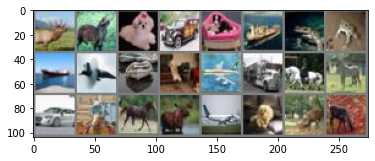

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(labels[0])



# show images
imshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
from cnn_model import net
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

net.to(torch.device("cuda:0"))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 2.302
[1,  2000] loss: 2.233
[2,  1000] loss: 1.915
[2,  2000] loss: 1.669
[3,  1000] loss: 1.564
[3,  2000] loss: 1.500
[4,  1000] loss: 1.437
[4,  2000] loss: 1.411
[5,  1000] loss: 1.364
[5,  2000] loss: 1.318
[6,  1000] loss: 1.290
[6,  2000] loss: 1.259
[7,  1000] loss: 1.231
[7,  2000] loss: 1.202
[8,  1000] loss: 1.169
[8,  2000] loss: 1.162
[9,  1000] loss: 1.114
[9,  2000] loss: 1.127
[10,  1000] loss: 1.080
[10,  2000] loss: 1.079
[11,  1000] loss: 1.040
[11,  2000] loss: 1.033
[12,  1000] loss: 1.000
[12,  2000] loss: 0.997
[13,  1000] loss: 0.962
[13,  2000] loss: 0.967
[14,  1000] loss: 0.931
[14,  2000] loss: 0.945
[15,  1000] loss: 0.901
[15,  2000] loss: 0.917
[16,  1000] loss: 0.882
[16,  2000] loss: 0.893
[17,  1000] loss: 0.859
[17,  2000] loss: 0.859
[18,  1000] loss: 0.824
[18,  2000] loss: 0.841
[19,  1000] loss: 0.807
[19,  2000] loss: 0.820
[20,  1000] loss: 0.780
[20,  2000] loss: 0.804
Finished Training


In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

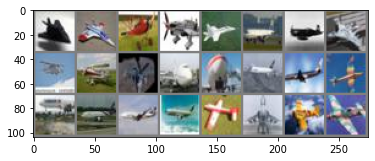

GroundTruth:  airplane airplane airplane airplane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print(images[0])
#print(labels[0])

# print images|
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [10]:
net.to('cpu')
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  airplane airplane horse cat  


In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        
        
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 72 %
